### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

2023-06-29 22:53:26.776381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 22:53:28.592596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


In [5]:
tf.reduce_sum(tf.random.normal([1000, 1000]))

2023-06-29 22:39:28.256863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3332 MB memory:  -> device: 0, name: Quadro P1000, pci bus id: 0000:3b:00.0, compute capability: 6.1


<tf.Tensor: shape=(), dtype=float32, numpy=-573.2451>

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

predictions = model(x_train[:1]).numpy()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss=loss_fn,
              metrics=['accuracy'])

In [8]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 11s 5ms/step - loss: 0.3013 - accuracy: 0.9128
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1451 - accuracy: 0.9570
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1106 - accuracy: 0.9663
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0908 - accuracy: 0.9716
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0766 - accuracy: 0.9754


In [17]:
import sys
print(sys.executable)

/home/ut3320/miniconda3/envs/biomed/bin/python


In [18]:
print(tf.__file__)

/home/ut3320/miniconda3/envs/biomed/lib/python3.9/site-packages/tensorflow/__init__.py


In [78]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle
import random
import pathlib
import datetime

from IPython import display
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from scipy.ndimage import gaussian_filter


In [79]:
class MidPointLogNorm(mcolors.LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mcolors.LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

In [80]:
tf.random.set_seed(seed=20)

In [88]:
### Hyperparameters
BATCH_SIZE = 128
EPOCH = 100

In [89]:
# inclusion = 'SOFT'
# inclusion = 'HARD'

In [90]:
os.mkdir(f'results') if(not os.path.isdir(f'results')) else None
folders = ['all_exp_plots_g', 'all_exp_plots', 'exp_plots', 'model_weights', 'raw_exps', 'training_plots', 'all_val_plots', 'raw_vals', 'training_plots_c']
for folder in folders:
    if(not os.path.isdir(f'results/{folder}')):
        os.mkdir(f'results/{folder}')

### Load dataset 

In [91]:
### Normalization

In [92]:
def add_noise_blur(image, rows=128, cols=128):
    #add random noise
    scale = tf.random.uniform([1], minval = 0.01, maxval = 0.1, dtype = tf.float32 )
    noise = tf.random.normal([rows, cols, 1], mean = 0.0, stddev = 1.0)
    #blur with a random sigma
    # sigmaIn = np.random.uniform(low = 1.0, high = 2.0 )
    sigmaIn = tf.random.uniform(shape=[], minval = 1.0, maxval = 2.0 )
    #image = gaussian_filter(image, sigma = sigmaIn)
    noise = gaussian_filter(noise, sigma = sigmaIn.numpy())
    image *= (1.0 + scale*noise)
    #print("scale %f sigma %f" % (scale, sigmaIn))
    return image

In [93]:
def normalize(dataY):
    max = tf.reduce_max(dataY)
    min = tf.reduce_min(dataY)
    # dataY = dataY / tf.math.abs(min)
    dataY = (dataY - min)/(max - min)
    return dataY

In [94]:
def normalizeTarget(image, bFlag = False):
    image = (image - 1.0) / (9.0)
    if bFlag:
        image = 2.0*image - 1.0
    return image

In [95]:
### EoNormalization

In [96]:
def load(image_file):
    # input_image = np.fromfile(image_file, dtype = 'float32', sep="")
    input_image = tf.io.read_file(image_file)
    input_image = tf.io.decode_raw(input_image, tf.float32)
    input_image = tf.reshape(input_image, (128,128))
    input_image = tf.expand_dims(input_image, -1)
    return input_image

In [97]:
def normalize_val(image, target):
    input_image = add_noise_blur(image)
    return input_image , target

In [98]:
def load_image_train(image_file, target_file):
    input_image = load(image_file)
    target_image = load(target_file)
    input_image = normalize(input_image)
    return input_image , target_image 

In [99]:
def load_image_val(image_file, target_file):    
    input_image = load(image_file)
    target_image = load(target_file)
    # input_image = add_noise_blur(image_file)
    input_image = normalize(input_image)

    return input_image , target_image 

In [100]:
def divide_paths(input_path,target_path,log_path):
    soft_input_path = []
    soft_target_path = []
    hard_input_path = []
    hard_target_path = []
    for ip, tp, lp in zip(input_path,target_path,log_path):
        with open(lp) as f:
            data = f.read()
        data = data.split(' ')
        mod = data[9]
        assert mod == 'mod1'
        mod_value = float(data[10].splitlines()[0])
        if mod_value < 1.0:
            soft_input_path.append(ip)
            soft_target_path.append(tp)
        if mod_value > 1.0:
            hard_input_path.append(ip)
            hard_target_path.append(tp)
    return soft_input_path,soft_target_path, hard_input_path, hard_target_path

In [101]:
# Data for checking
# input_path = glob.glob('Data/TrainingData/*/uY_128x128.raw')
# target_path = glob.glob('Data/TrainingData/*/modulus_128x128.raw')

In [102]:
# Data for mu=10mu
# input_path = glob.glob('../../alldata2/DataInclusions_7_7_2022_PStress/TrainingData/*/uY_128x128.raw')
# target_path = glob.glob('../../alldata2/DataInclusions_7_7_2022_PStress/TrainingData/*/modulus_128x128.raw')

In [103]:
input_path = glob.glob('../../alldata2/DataInclusions_7_7_2022_PStress/TrainingData/*/uY_128x128.raw')
target_path = glob.glob('../../alldata2/DataInclusions_7_7_2022_PStress/TrainingData/*/modulus_128x128.raw')
log_path = glob.glob('../../alldata2/DataInclusions_7_7_2022_PStress/TrainingData/*/logFile.txt')
input_path.sort(key= lambda x: int(x.split('/')[-2]))
target_path.sort(key= lambda x: int(x.split('/')[-2]))
log_path.sort(key= lambda x: int(x.split('/')[-2]))

In [104]:
# soft_input_path,soft_target_path, hard_input_path, hard_target_path = divide_paths(input_path,target_path,log_path)

In [105]:
# print(len(soft_input_path))
# print(len(soft_target_path))
# print(len(hard_input_path))
# print(len(hard_target_path))

In [106]:
input_val_path = glob.glob('../../alldata2/DataInclusions_7_7_2022_PStress/ValData/*/uY_128x128.raw')
target_val_path = glob.glob('../../alldata2/DataInclusions_7_7_2022_PStress/ValData/*/modulus_128x128.raw')
log_val_path = glob.glob('../../alldata2/DataInclusions_7_7_2022_PStress/ValData/*/logFile.txt')
input_val_path.sort(key= lambda x: int(x.split('/')[-2]))
target_val_path.sort(key= lambda x: int(x.split('/')[-2]))
log_val_path.sort(key= lambda x: int(x.split('/')[-2]))

In [107]:
# soft_input_val_path,soft_target_val_path, hard_input_val_path, hard_target_val_path = divide_paths(input_val_path,target_val_path,log_val_path)

In [108]:
# print(len(soft_input_val_path))
# print(len(soft_target_val_path))
# print(len(hard_input_val_path))
# print(len(hard_target_val_path))

In [109]:
# if inclusion == 'SOFT':
#     input_path = soft_input_path
#     target_path = soft_target_path
#     input_val_path = soft_input_val_path
#     target_val_path = soft_target_val_path
# elif inclusion == 'HARD':
#     input_path = hard_input_path
#     target_path = hard_target_path
#     input_val_path = hard_input_val_path
#     target_val_path = hard_target_val_path
# else:
#     print('Whoops')
    

In [110]:
# train_dataset
train_dataset = tf.data.Dataset.from_tensor_slices((input_path, target_path))
train_dataset = train_dataset.map(load_image_train)

In [111]:
len(train_dataset)

10000

In [112]:
train_dataset = train_dataset.batch(1)

In [113]:
#  for i, a_train_data in enumerate(train_dataset):
#     target_image = a_train_data[1]
#     plt.imshow(target_image, cmap='gray')
#     plt.colorbar(location='right')
#     plt.savefig(f'training_targets/{i+1}.png')
#     plt.close()#

In [114]:
### Print training datas

In [115]:
manual_ex = [8,48,7,53]

In [116]:
max_values = []
min_values = []
input = []
target = []
for i, a_train_data in enumerate(train_dataset):
    if i+1 in manual_ex:
        input_image = a_train_data[0]
        target_image = a_train_data[1]
        input.append(input_image)
        target.append(target_image)

        maxx= tf.math.reduce_max(target_image)
        max_values.append(maxx.numpy())

        minn= tf.math.reduce_min(target_image)
        min_values.append(minn.numpy())

In [117]:
max(max_values), min(min_values)

(4.828581, 0.39660633)

In [118]:
# plt.figure(figsize=(15,15))
# plt.tight_layout()
# for i in range(4):
#     plt.subplot(1, 4, i+1)
#     plt.imshow(input[i][0], cmap='gray')
#     plt.colorbar(location='bottom', pad=0.05)
#     plt.suptitle('Displacement distribution', x=0.5, y = 0.48, fontsize=15)

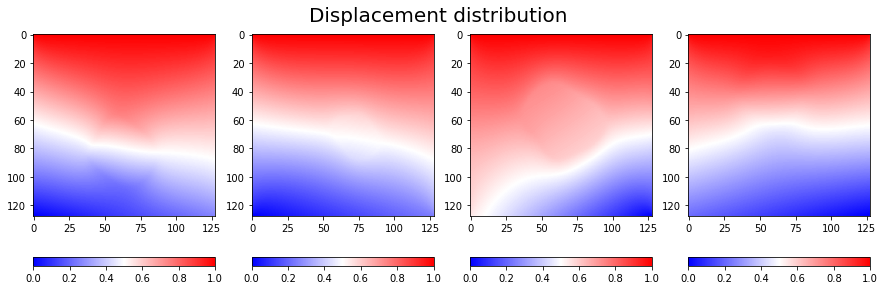

In [119]:
plt.figure(figsize=(15,15))
plt.tight_layout()
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(input[i][0], cmap='bwr')
    plt.colorbar(location='bottom', pad=0.05)
    plt.suptitle('Displacement distribution', x=0.5, y = 0.47, fontsize=20)

In [120]:
# plt.figure(figsize=(15,15))
# plt.tight_layout()
# for i in range(4):
#     plt.subplot(1, 4, i+1)
#     plt.imshow(target[i][0], cmap='gray')
#     plt.colorbar(location='bottom', pad=0.05)
#     plt.suptitle('Modulus distribution', x=0.5, y = 0.48, fontsize=15)

In [121]:
# plt.figure(figsize=(15,15))
# plt.tight_layout()
# for i in range(4):
#     plt.subplot(1, 4, i+1)
#     plt.imshow(target[i][0], cmap='gray', norm= mcolors.LogNorm(vmin=0.1, vmax=5))
#     plt.colorbar(location='bottom', pad=0.05)
#     plt.suptitle('Modulus distribution', x=0.5, y = 0.48, fontsize=15)

In [122]:
class MidPointLogNorm(mcolors.LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mcolors.LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

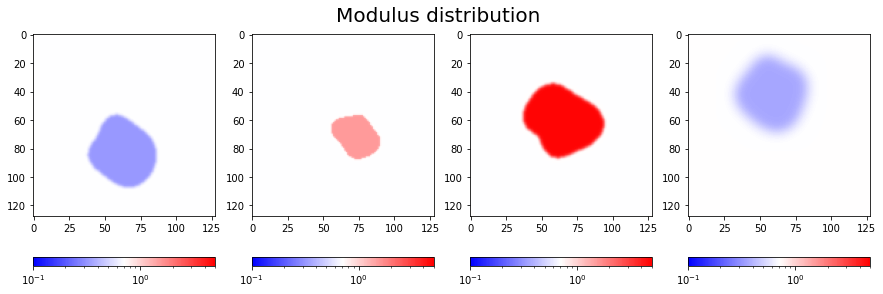

In [124]:
plt.figure(figsize=(15,15))
plt.tight_layout()
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(target[i][0], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    plt.colorbar(location='bottom', pad=0.05)
    plt.suptitle('Modulus distribution', x=0.5, y = 0.47, fontsize=20)

In [125]:
# train data

In [126]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_path, target_path))
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(buffer_size=len(input_path)) 
train_dataset = train_dataset.batch(BATCH_SIZE)

In [127]:
### Val data

In [128]:
## val_dataset
val_dataset = tf.data.Dataset.from_tensor_slices((input_val_path, target_val_path))
val_dataset = val_dataset.map(load_image_val)
# val_dataset = val_dataset.shuffle(buffer_size=len(input_val_path)) 
# val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(1)

In [129]:
train_dataset

<BatchDataset shapes: ((None, 128, 128, 1), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

In [130]:
val_dataset

<BatchDataset shapes: ((None, 128, 128, 1), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

In [131]:
# print(len(dataset))
print(len(train_dataset))
print(len(val_dataset))
# print(len(test_dataset))

79
1000


In [132]:
a = next(iter(train_dataset))
print(len(a))
print(a[0].shape)
print(a[1].shape)

2
(128, 128, 128, 1)
(128, 128, 128, 1)


In [133]:
inp, re = a[0][0], a[1][0]

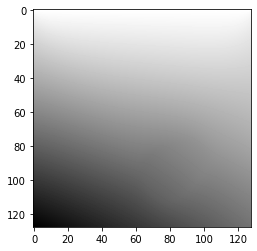

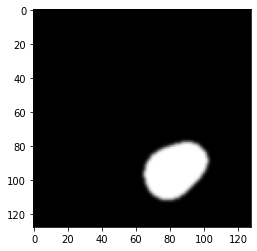

In [134]:
plt.figure()
plt.imshow(inp, cmap='gray')
plt.figure()
plt.imshow(re, cmap='gray')

### Generator Model

In [135]:
OUTPUT_CHANNELS = 1

In [136]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [137]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 64, 64, 3)


In [138]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [139]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


In [140]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])

    down_stack = [
        downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 3),  # (batch_size, 64, 64, 128)
        downsample(256, 3),  # (batch_size, 32, 32, 256)
        downsample(512, 3),  # (batch_size, 16, 16, 512)
        downsample(512, 3),  # (batch_size, 8, 8, 512)
        downsample(512, 3),  # (batch_size, 4, 4, 512)
        downsample(512, 3),  # (batch_size, 2, 2, 512)
        # downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        # upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 3, apply_dropout=False),  # (batch_size, 8, 8, 1024)
        upsample(512, 3),  # (batch_size, 16, 16, 1024)
        upsample(256, 3),  # (batch_size, 32, 32, 512)
        upsample(128, 3),  # (batch_size, 64, 64, 256)
        upsample(64, 3),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='sigmoid')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # x = last(x)
    # x = 1.0 + (10.0 - 1.0)*x 

    upsampling = tf.keras.layers.UpSampling2D(size=2, interpolation = 'bilinear')
    # last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='relu')
    last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')
    multiply = tf.keras.layers.Lambda(lambda x: 0.1 + (5.0 - 0.1)*x)
    
    x = upsampling(x)
    x = last_conv(x)
    x = multiply(x)
    
    # x = 0.1 + (10.0 - 0.1)*x
    # this one for both!

    return tf.keras.Model(inputs=inputs, outputs=x)

In [141]:
# Visualizing generator architecture
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

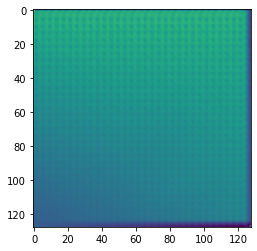

In [142]:
# Testing the generator
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [143]:
gen_output.shape

TensorShape([1, 128, 128, 1])

In [144]:
# Generator loss
LAMBDA = 100
loss_object = tf.keras.losses.MeanSquaredError()
loss_tracker = tf.keras.metrics.Mean(name="loss")
val_loss_tracker = tf.keras.metrics.Mean(name="loss")

In [145]:
def generator_loss(gen_output, target):
    #Possible addition: regularizer
    gan_loss = loss_object(gen_output, target)
    return gan_loss

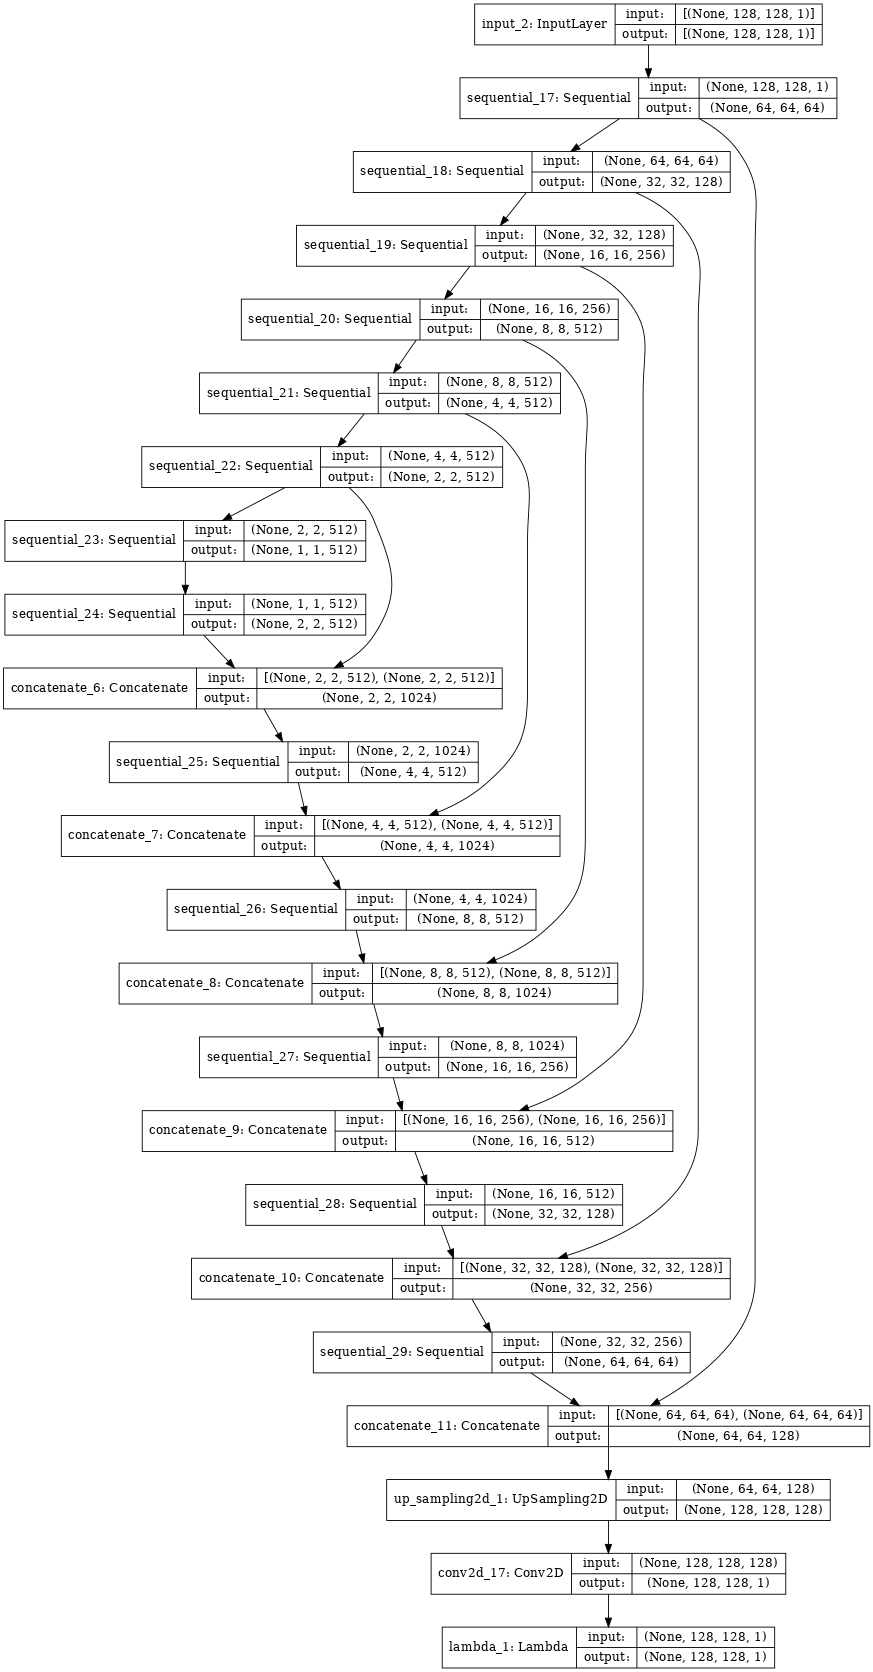

In [146]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, to_file='results/model.png')

### Optimizers and checkpoints

In [147]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [148]:
checkpoint_dir = 'training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 generator=generator,
                                )

In [149]:
def generate_images(model, test_input, tar, epoch, step):
    prediction = model(test_input, training=True)
    display_list = [test_input[0], tar[0], prediction[0]]
    mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Input Image', 'Ground Truth', f'Predicted {mse_loss:.2f} {mape_loss:.2f}%']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.colorbar(location='bottom')
        plt.axis('off')
    plt.savefig(f'results/training_plots/{epoch}-{step}.png')

In [150]:
plt.tight_layout()
def generate_images8(model, test_input, tar, epoch, step):
    prediction = model(test_input, training=True)

    x = prediction.numpy()
    if np.amax(x) > 1.0:
        x[x < 1.0] = 1.0
    else:
        x[x > 1.0] = 1.0

    display_list = [test_input[0], tar[0], x[0]]
    mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Input Image', 'Ground Truth', f'Predicted'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i], fontsize=25)
        if i==0:
            plt.imshow(display_list[i], cmap='bwr')
            plt.colorbar(location='bottom',pad=0.1)
        else:
            plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
            plt.colorbar(location='bottom',pad=0.1)
        plt.axis('on')
    plt.savefig(f'results/training_plots_c/{epoch}-{step}.png', bbox_inches='tight')

    # plt.imshow(target[i][0], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    # plt.colorbar(location='bottom', pad=0.05)
    # plt.suptitle('Modulus distribution', x=0.5, y = 0.48, fontsize=15)

<Figure size 432x288 with 0 Axes>

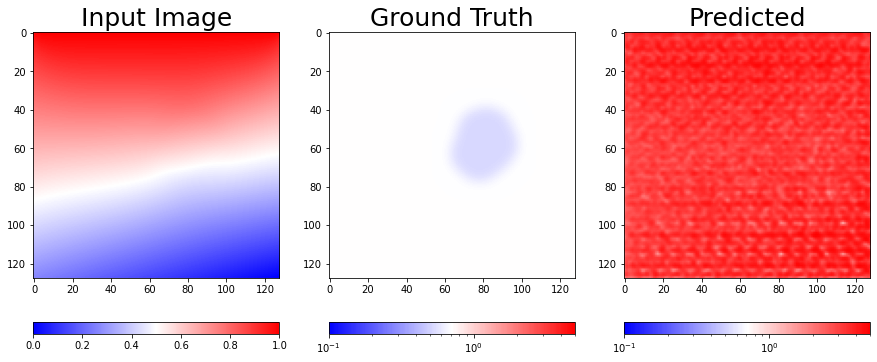

In [151]:
for example_input, example_target in val_dataset.take(1):
    generate_images8(generator, example_input, example_target,6,6)

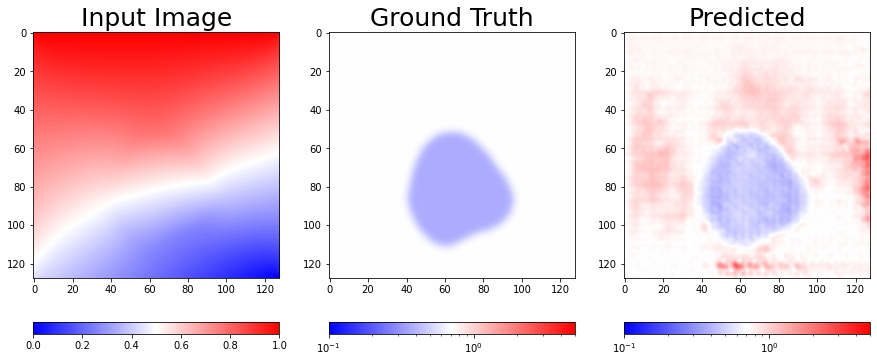

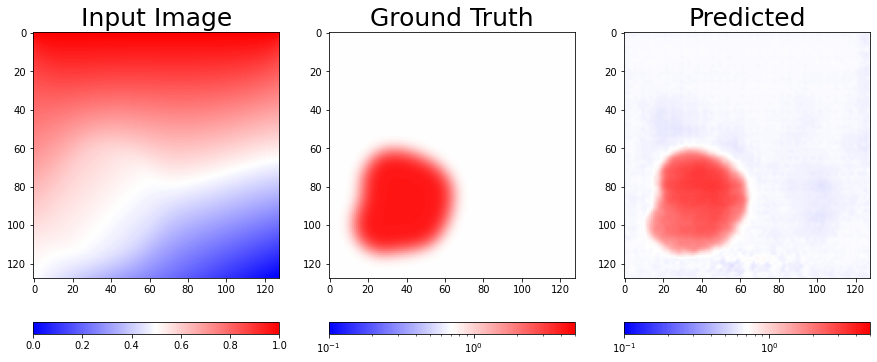

In [174]:
for i, (example_input, example_target) in enumerate(val_dataset.take(1000)):
    if i+1 == 49 or i+1 == 174:
        generate_images8(generator, example_input, example_target,i+1,i+1)

### Training

In [153]:
MODEL_PATH = "results/model_weights/mse_model"
BEST_PATH = "results-1/model_weights/best_mse_model"

In [154]:
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
gen_total_loss_list = []
gen_val_loss_list = []

In [155]:
# @tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape:
        gen_output = generator(input_image, training=True)
        gen_total_loss = generator_loss(gen_output, target)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    if step%9998 == 0:
        gen_total_loss_list.append(gen_total_loss.numpy())
        loss_tracker.update_state(gen_total_loss)
    # print(f'Result:{loss_tracker.result()}')

    # with summary_writer.as_default():
    #     tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)

In [156]:
def val_step(input_image, target, step):
    
    gen_output = generator(input_image, training=False)
    gen_val_loss = generator_loss(gen_output, target)
    
    gen_val_loss_list.append(gen_val_loss)
    val_loss_tracker.update_state(gen_val_loss)

In [157]:
### Exp data OTG

In [158]:
def generate_images2(model, test_input, epoch, step):
    prediction = model(test_input, training=False)
    display_list = [test_input[0], prediction[0]]
    title = ['Input', 'Predicted']
    for i in range(2):
        plt.ioff()
        plt.subplot(1, 2, i+1)
        plt.title(title[i], fontsize=15)
        if i ==0:
            plt.imshow(display_list[i], cmap='bwr')
        else:
            plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
        plt.colorbar(location='bottom',pad=0.10)
        plt.axis('on')
    plt.axis('on')
    plt.savefig(f'results/exp_plots/{epoch}-{step}.png',bbox_inches='tight')

In [159]:
path_to_exp_image = "../../alldata/ExpData_7_27_2021/10/uy_128x128.raw"
exp_img = load(path_to_exp_image)
exp_img = normalize(exp_img)
exp_img = exp_img[tf.newaxis, ...]

In [205]:
def generate_images2_p(model, test_input, epoch, step):
    prediction = model(test_input, training=False)

    x = prediction.numpy()
    if np.amax(x) > 1.0:
        x[x < 1.0] = 1.0
    else:
        x[x > 1.0] = 1.0

    display_list = [test_input[0], x[0]]
    title = ['Input', 'Predicted']
    for i in range(2):
        plt.ioff()
        plt.subplot(1, 2, i+1)
        plt.title(title[i], fontsize=15)
        if i ==0:
            plt.imshow(display_list[i], cmap='bwr')
        else:
            plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
        plt.colorbar(location='bottom',pad=0.10)
        plt.axis('on')
    plt.axis('on')
    plt.savefig(f'results/exp_plots/{epoch}-{step}.png',bbox_inches='tight')

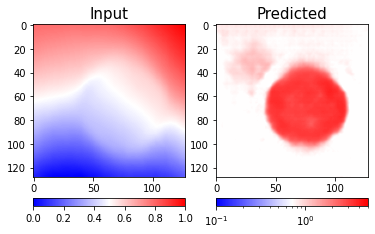

In [206]:
generate_images2_p(generator, exp_img, 5,6)

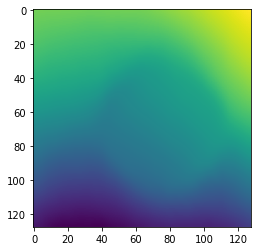

In [182]:
plt.imshow(exp_img[0])

In [195]:
prediction = generator(exp_img, training=False)
prediction[0].shape

TensorShape([128, 128, 1])

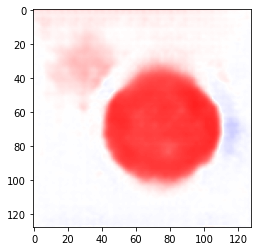

In [199]:
plt.imshow(prediction[0], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1.0))

In [202]:
x = prediction.numpy()
if np.amax(x) > 1.0:
    x[x < 1.0] = 1.0
else:
    x[x > 1.0] = 1.0

In [204]:
np.amax(x)

4.026088

In [ ]:
x[x < 1.0] = 1.0

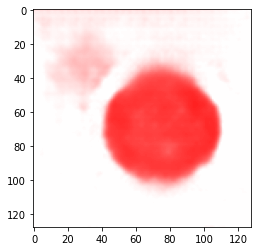

In [201]:
plt.imshow(x[0],cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1.0))

In [190]:
threshold = 1
elements_gt = tf.math.greater(x,threshold)
num_elements_gt = tf.math.reduce_sum(tf.cast(elements_gt, tf.int32))
print(num_elements_gt)

tf.Tensor(10193, shape=(), dtype=int32)


In [ ]:
result = tf.where(prediction>1.0, prediction,1.0)


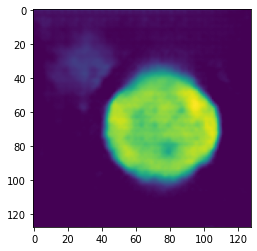

In [193]:
plt.imshow(x[0])

In [161]:
# min_val_loss = 1000;

In [162]:
epoch_wise_train_loss = []
epoch_wise_val_loss = []

In [163]:
def fit(train_ds, val_ds, epochs, steps=len(train_dataset)):
    example_input, example_target = next(iter(train_ds.take(1)))
    start = time.time()
    min_val_loss = 1000
    
    for epoch in range(epochs):
        for step, (input_image, target) in train_ds.repeat(1).take(steps).enumerate():
            train_step(input_image, target, step)
            if (step)%9998==0:
                # 1 times per epoch 
                for (input_image, target) in val_ds.take(500):
                    val_step(input_image, target, step)
            # display.clear_output(wait=True)

        ## Save best model
        current_loss = val_loss_tracker.result().numpy()
        print("current loss",current_loss)
        print("Min vall loss",min_val_loss)
        if(current_loss < min_val_loss and epoch > 2):
            min_val_loss = current_loss
            generator.save_weights(BEST_PATH)
            print(f"Saving best weight with val loss:{min_val_loss} to {BEST_PATH}")

        if (epoch) % 10 == 0:
            # display.clear_output(wait=True)
            if epoch != 0:
                print(f'Time taken for 10 epochs: {time.time()-start:.2f} sec\n')
            start = time.time()
            # generate_images(generator, example_input, example_target, epoch, step)
            print(f"Reached epoch: {epoch}")
            # generate_images2(generator, exp_img, epoch, step)    

        # Save (checkpoint) the model every 25 EPOCH
        if (epoch)%50 == 0:
            print(f"Saving checkpoint at epoch:{epoch}")
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Step: {step}, Train Loss:{loss_tracker.result()} , Val Loss:{val_loss_tracker.result()}")
        
        print(f"Epoch: {epoch}, Train Loss:{loss_tracker.result()} , Val Loss:{val_loss_tracker.result()}")
        epoch_wise_train_loss.append(loss_tracker.result())
        epoch_wise_val_loss.append(val_loss_tracker.result())
        loss_tracker.reset_states()
        val_loss_tracker.reset_states()

    generator.save_weights(MODEL_PATH)
    print(f'\nModel saved to: {MODEL_PATH}')
    print('min_val_loss',min_val_loss)
    with open('results/loss.txt','w') as f:
        f.write(str(min_val_loss))

In [164]:
fit(train_dataset,val_dataset, epochs=EPOCH)

current loss 2.4193082
Min vall loss 1000
Reached epoch: 0
Saving checkpoint at epoch:0
Step: 78, Train Loss:6.847898006439209 , Val Loss:2.4193081855773926
Epoch: 0, Train Loss:6.847898006439209 , Val Loss:2.4193081855773926
current loss 1.587821
Min vall loss 1000
Epoch: 1, Train Loss:0.11094652861356735 , Val Loss:1.5878210067749023
current loss 1.2417035
Min vall loss 1000
Epoch: 2, Train Loss:0.04843193292617798 , Val Loss:1.2417035102844238
current loss 0.93239266
Min vall loss 1000
Saving best weight with val loss:0.9323926568031311 to results-1/model_weights/best_mse_model
Epoch: 3, Train Loss:0.1023501604795456 , Val Loss:0.9323926568031311
current loss 0.6066432
Min vall loss 0.93239266
Saving best weight with val loss:0.6066431999206543 to results-1/model_weights/best_mse_model
Epoch: 4, Train Loss:0.09888217598199844 , Val Loss:0.6066431999206543
current loss 0.7125143
Min vall loss 0.6066432
Epoch: 5, Train Loss:0.019105637446045876 , Val Loss:0.7125142812728882
current lo

In [165]:
len(gen_total_loss_list)

100

In [166]:
len(gen_val_loss_list)

50000

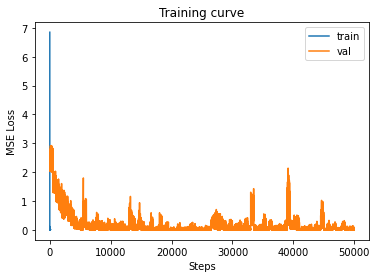

In [167]:
# plt.figure(figsize=(20, 15))
plt.plot(gen_total_loss_list, label='train')
plt.plot(gen_val_loss_list, label='val')
plt.title("Training curve")
plt.xlabel("Steps")
plt.ylabel("MSE Loss")
plt.legend()
plt.savefig('results/train_val_curve.png')
plt.show()


In [168]:
l1 = len(epoch_wise_train_loss)
l2 = len(epoch_wise_val_loss)
print(l1)
print(l2)
a = range(1,l1+1)
b = range(1,l2+1)

100
100


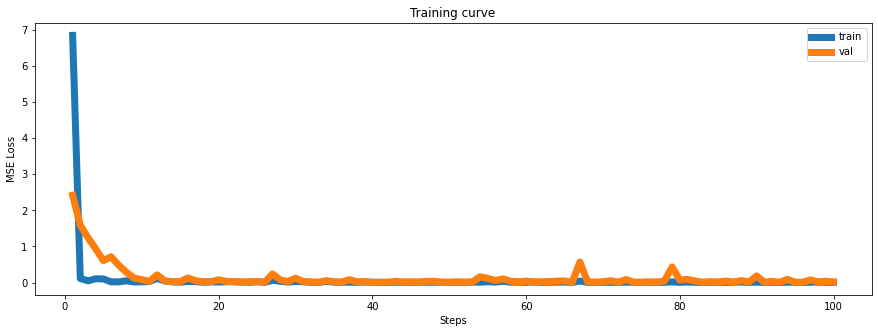

In [169]:
plt.figure(figsize=(15,5))
plt.plot(a, epoch_wise_train_loss, label='train', linewidth=7.0)
plt.plot(a, epoch_wise_val_loss, label='val', linewidth=7.0)
plt.title("Training curve")
plt.xlabel("Steps")
plt.ylabel("MSE Loss")
plt.legend()
plt.savefig('results/train_val_epoch_curve.png')
plt.show()

In [170]:
with open("epoch_wise_train_loss", "wb") as fp:   
    pickle.dump(epoch_wise_train_loss, fp)
with open("epoch_wise_val_loss", "wb") as fp:   
    pickle.dump(epoch_wise_val_loss, fp)

In [171]:
print(f'Train MSE at the end of training: {gen_total_loss_list[-1]}')
print(f'Val MSE at the end of training: {gen_val_loss_list[-1]}')

Train MSE at the end of training: 0.006725338753312826
Val MSE at the end of training: 0.0034712443593889475


### Testing

In [172]:
generator.load_weights(BEST_PATH)

In [173]:
len(val_dataset)

1000

In [104]:
avg_mse_loss_list = []
avg_mape_loss_list = []

i = 0
for test_image,test_target in val_dataset:
    test_prediction = generator(test_image,training=False)
    test_target = test_target
    mse_loss = tf.keras.metrics.mean_squared_error(test_target, test_prediction)
    avg_mse_loss = tf.math.reduce_mean(mse_loss).numpy()
    avg_mse_loss_list.append(avg_mse_loss)

    mape_loss =  tf.keras.metrics.mean_absolute_percentage_error(test_target, test_prediction)
    avg_mape_loss = tf.math.reduce_mean(mape_loss).numpy()
    avg_mape_loss_list.append(avg_mape_loss)

    output = np.reshape(test_prediction, (128,128))
    gt = np.reshape(test_target, (128,128))
    i = i+1

    file_name = f"results/raw_vals/{i}-pred.raw"
    with open(file_name, 'wb') as fp:     
        output.tofile(fp)
    fp.close()

    file_name2 = f"results/raw_vals/{i}-gt.raw"
    with open(file_name2, 'wb') as fp:     
        gt.tofile(fp)
    fp.close()

In [105]:
len(avg_mse_loss_list)

1000

In [106]:
final_mse = sum(avg_mse_loss_list)/len(avg_mse_loss_list)
with open('results/loss.txt','a') as f:
    f.write(f'\nFinal_MSE:{final_mse}')
final_mse

0.0017156673624940594

In [107]:
len(avg_mape_loss_list)

1000

In [108]:
final_mape = sum(avg_mape_loss_list)/len(avg_mape_loss_list)
with open('results/loss.txt','a') as f:
    f.write(f'\nFinal_MAPE:{final_mape}')
final_mape

1.0968225829899312

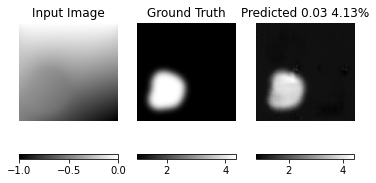

In [109]:
i = 0
for test_image,test_target in val_dataset:
    i = i+1
    if i in [49, 174]:
        generate_images(generator, test_image, test_target,'val-',i)

KeyboardInterrupt: 

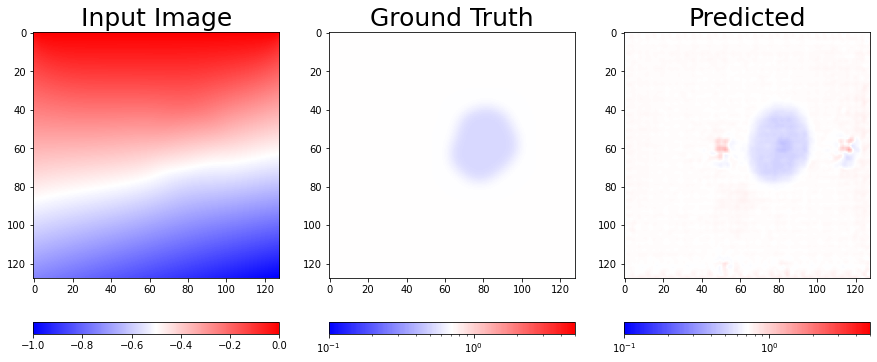

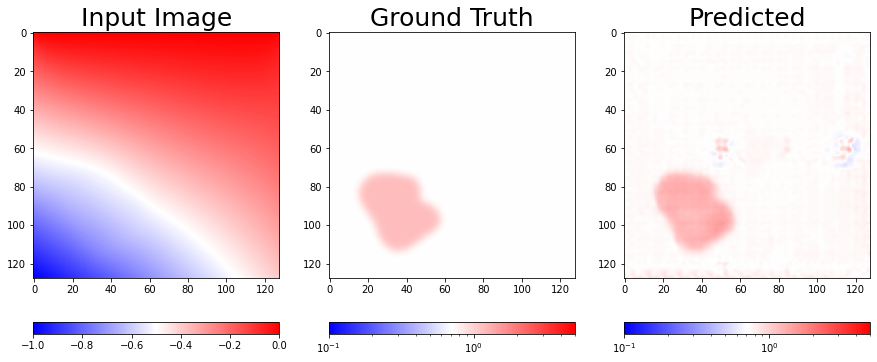

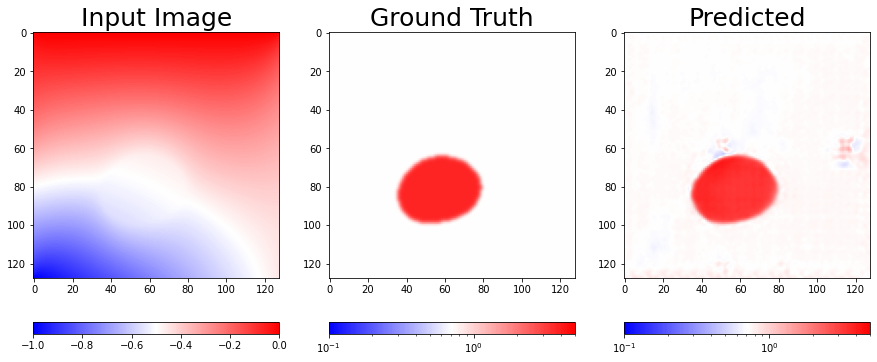

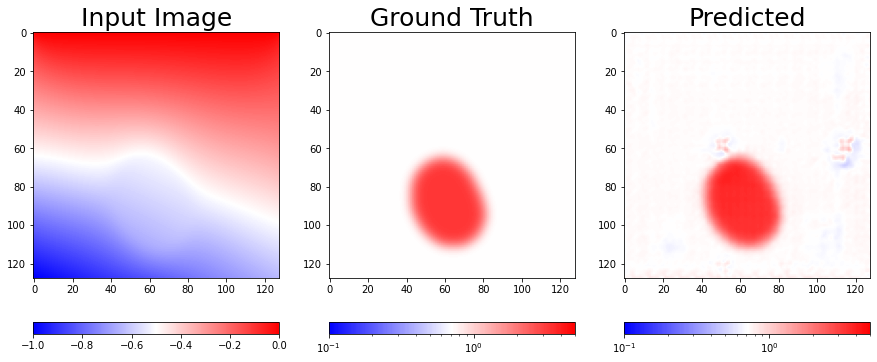

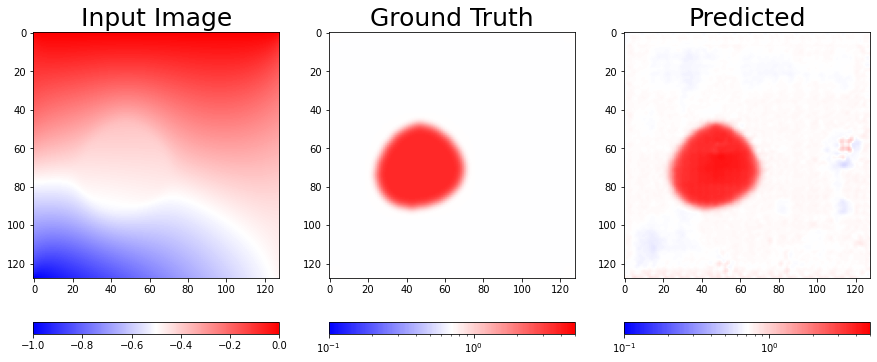

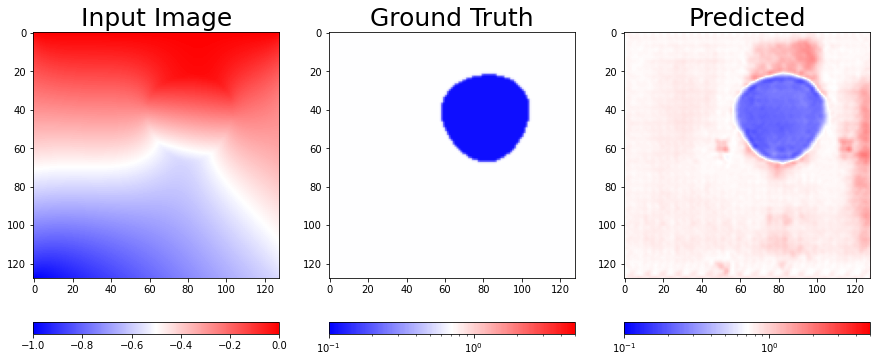

In [110]:
i = 0
for test_image,test_target in val_dataset:
    i = i+1
    generate_images8(generator, test_image, test_target,'val2222-',i)

In [ ]:
# Generate plots for test set
# for i, (test_input, test_target) in val_dataset.take(500).enumerate():
#     generate_images(generator, test_input, test_target,'test',i)

In [ ]:
### Output for all exp data

In [176]:
exp_image_path =  "../../alldata2/DataInclusions_7_7_2022_PStress/ExpData_7_27_2021/*/uy_128x128.raw"
exp_images = glob.glob(exp_image_path)
len(exp_images)

45

In [ ]:
### Save all outputs to raw
all_images_min_max_values = []
# Writing it raw
for exp_image in exp_images:
    exp_img = load(exp_image)
    exp_img = normalize(exp_img)
    exp_img = exp_img[tf.newaxis, ...]
    name = exp_image.split('/')[-2]
    
    prediction = generator(exp_img, training=False)
    output = np.reshape(prediction, (128,128))

    file_name = f"results/raw_exps/{name}.raw"
    with open(file_name, 'wb') as fp:     
        output.tofile(fp)
    fp.close()

    max_val = np.amax(prediction)
    min_val = np.amin(prediction)
    all_images_min_max_values.append((name,min_val,max_val))

In [ ]:
# all_images_min_max_values.sort(key=lambda x: int(x[0]))
# all_images_min_max_values

In [ ]:
def generate_images3(model, test_input, epoch, step):
    plt.ioff()
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.ioff()
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        # plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
        plt.imshow(display_list[i], cmap='RdBu')
        plt.colorbar(location='bottom')
        plt.axis('off')
    plt.ioff()
    # plt.show()
    plt.axis('off')
    plt.savefig(f'results/all_exp_plots/{epoch}-{step}.png')
    # plt.show()

In [ ]:
def generate_images4(model, test_input, epoch, step):
    plt.ioff()
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.ioff()
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        # plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
        plt.imshow(display_list[i], cmap='gray')
        plt.colorbar(location='bottom')
        plt.axis('off')
    plt.ioff()
    # plt.show()
    plt.axis('off')
    plt.savefig(f'results/all_exp_plots_g/{epoch}-{step}.png')
    # plt.show()

37
3


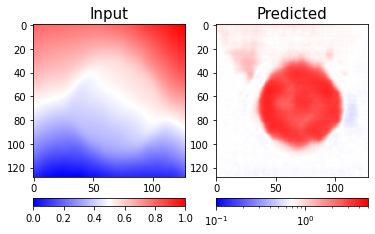

In [177]:
for exp_image in exp_images:
    exp_img = load(exp_image)
    exp_img = normalize(exp_img)
    exp_img = exp_img[tf.newaxis, ...]
    name = exp_image.split('/')[-2]
    if name == '3' or name == '37':
        print(name)
        generate_images2(generator, exp_img, name, name)
    # generate_images3(generator, exp_img, name, name)
    # generate_images4(generator, exp_img, name, name)

In [ ]:
## Calculate modulus

In [ ]:
# all_raw_data_path = 'raw_exps/*.raw'
# all_raw_data = glob.glob(all_raw_data_path)

In [ ]:
# all_raw_data.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
# all_raw_data

In [ ]:
# threshold = 0.45

In [ ]:
# all_modulus = []

In [ ]:
# for a_data in all_raw_data:
#     img = np.fromfile(a_data,dtype = 'float32', sep="")
#     name = a_data.split('/')[-1].split('.')[0]
#     modulus = img[img<threshold]
#     if len(modulus) != 0:
#         avg_modulus = sum(modulus)/len(modulus)
    
#     all_modulus.append((name,avg_modulus))

#     with open('modulus_values.txt', 'a') as f:
#         f.write(f"{name},{avg_modulus}\n")
    
    

In [ ]:
# for i in all_modulus:
#     print(i)